<a href="https://colab.research.google.com/github/abhinaash-broski/ANAIS25/blob/main/Generative_Models_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models Practical

Welcome to the Generative Models Practical. This lab has two parts:

1) **Flow Matching with TorchCFM.** In this section, you will use TorchCFM:
https://github.com/atong01/conditional-flow-matching. Learning how to use these libraries is an important step when working on generative-modeling projects. We will learn a simple vector field between two 2D distributions and then generate samples from it.


2) **Mathematical foundations.** The mathematical questions are meant to introduce you to the world of mathematics behind modern generative models. Treat these questions as a starting point for exploration, and solve them if you find them interseting. You are welcome to use LLM agents to support this exploration.



## 1. Introduction to Flow Matching

Now by using torccfm we will create a flow matching model that will learn a vector field from gaussian to two moons learning to generate new samples.

In [ ]:
#@title Installing Libraries

!pip install torchcfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.4 MB/s eta 0:00:00


In [ ]:
#@title Important Libraries


import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch import Tensor
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *


savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)



# Base distribution
def sample_8gaussians(n, dim=2, scale=5, var=0.1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim, dtype=torch.float32),
        torch.sqrt(torch.tensor(var, dtype=torch.float32)) * torch.eye(dim)
    )

    centers = torch.tensor([
        (1, 0), (-1, 0), (0, 1), (0, -1),
        (1/np.sqrt(2),  1/np.sqrt(2)),
        (1/np.sqrt(2), -1/np.sqrt(2)),
        (-1/np.sqrt(2),  1/np.sqrt(2)),
        (-1/np.sqrt(2), -1/np.sqrt(2)),
    ], dtype=torch.float32) * scale

    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)

    data = centers[multi] + noise
    return data



# Target distribution
def sample_moons(n_samples, noise=0.2):
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - .5

    X = np.vstack([
        np.append(outer_circ_x, inner_circ_x),
        np.append(outer_circ_y, inner_circ_y)
    ]).T

    if noise is not None:
        X += np.random.rand(n_samples, 1) * noise

    X = torch.from_numpy(X).float()
    return X * 3 - 1

### Q1. Warm up debbuging
The following neural network code has some errors, fix them.

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(2*w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, 5*w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)



### Q2. Debugging the class used for generation

In the class below, we implement the main building blocks needed to train a flow-matching model. As seen in the lecture, the interpolated point at time t is defined by

$$x_t = (1 - t)\,x_0 + t\,x_1,$$

and the corresponding target (conditional) flow is

$$u_t(x_t) = x_1 - x_0.$$

Task:
Check that the class implements these two formulas correctly. If any parts are missing or incorrect, fix them so that the outputs match the definitions above.



In [ ]:
class ConditionalFlowMatcher:
    def xt(self, x0, x1, t):
        t = pad_t_like_x(t, x0)
        return 2*t * x1 + (1 - t) * x0 +4

    def ut(self, x0, x1):
        return 2 * x1 - x0

    def sample_location_and_conditional_flow(self, x0, x1, t=None):
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"

        xt = self.xt(x0, x1, t)
        ut = self.ut(x0, x1)

        return t, xt, ut


### Q3. Debugging the class used for generation

In the next cell, you will implement a training loop that learns a vector field.

**Task:**  
Check that the class implements the two formulas correctly. If any parts are missing or incorrect, fix them so that the outputs match the definitions given above.


5000: loss 8.877 time 19.52


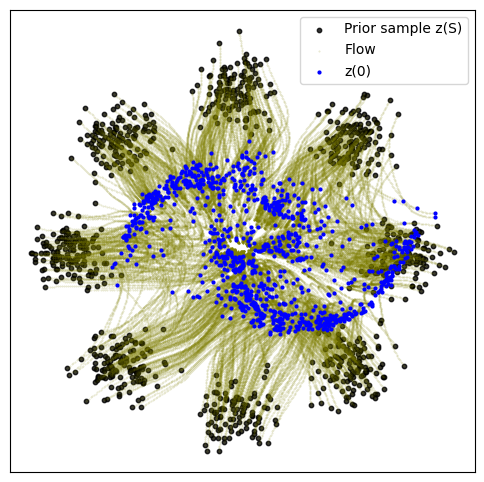

10000: loss 8.705 time 17.50


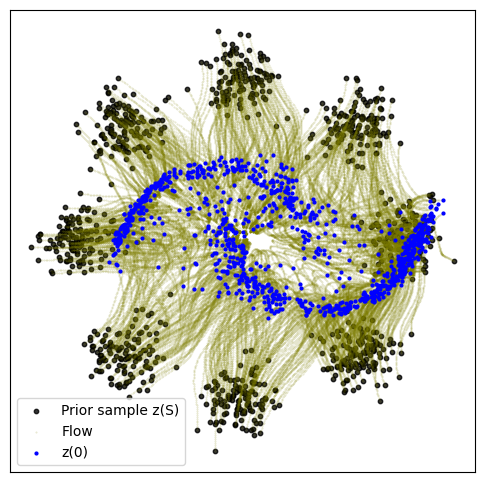

15000: loss 8.574 time 14.93


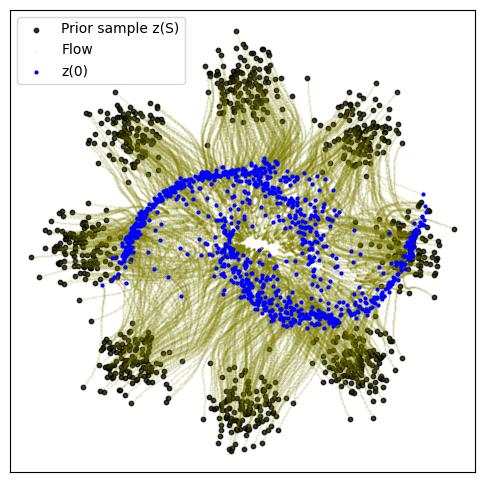

20000: loss 8.955 time 14.89


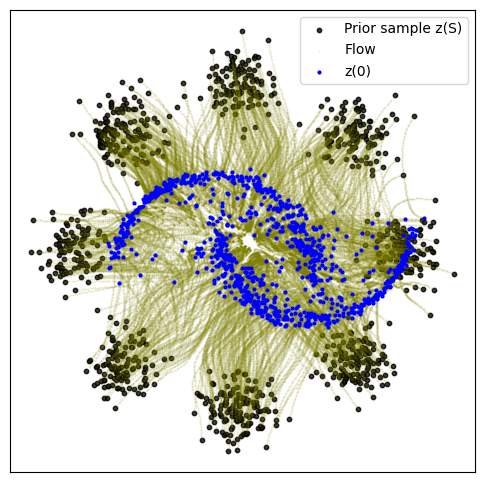

CPU times: user 1min 1s, sys: 278 ms, total: 1min 1s
Wall time: 1min 8s


In [ ]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher()

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size, dim=2, scale=5,var=0.1)
    x1 = sample_moons(batch_size)

    t, xt, ut, l = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - 2 * ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/cfm_v1.pt")

### Q4. Changing the source and target distributions

In the code above, we learned a vector field that maps a source distribution (an 8-component Gaussian mixture) to a target distribution (the two half-moons dataset). However, flow matching can be used to learn vector fields between many different pairs of distributions.

Task:
Write a training loop that learns to generate samples from the Swiss roll distribution, starting from a Gaussian source distribution.


5000: loss 0.014 time 11.43


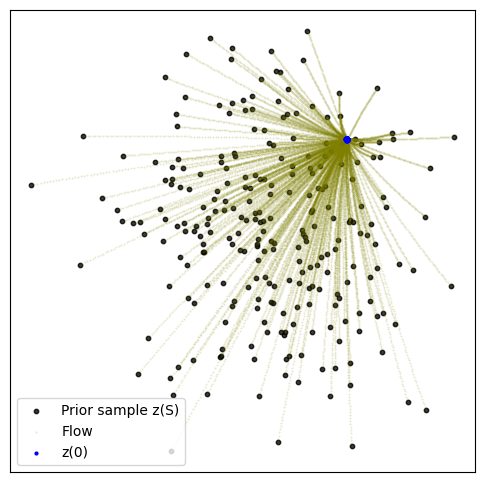

10000: loss 0.006 time 11.17


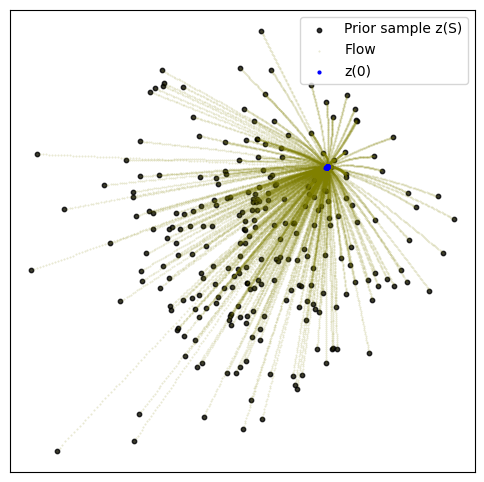

15000: loss 0.005 time 10.83


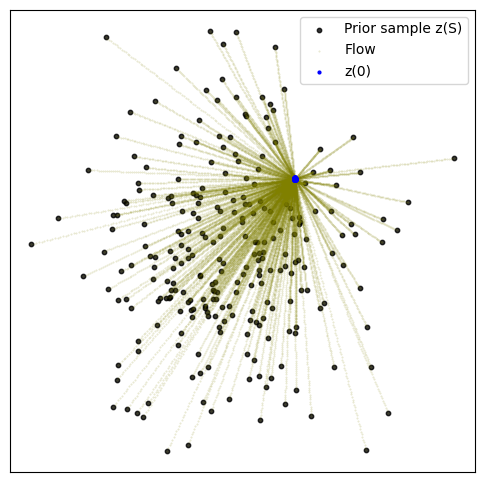

20000: loss 0.002 time 11.00


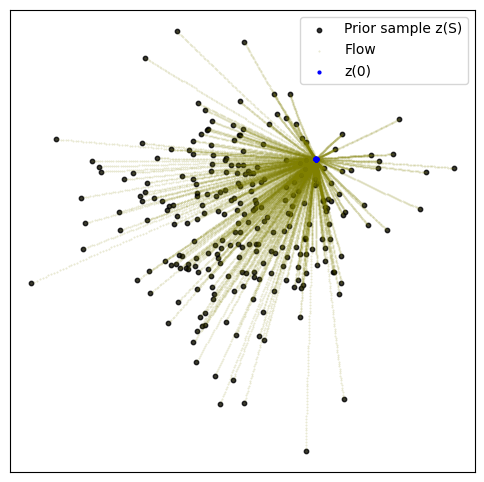

CPU times: user 43.8 s, sys: 110 ms, total: 44 s
Wall time: 44.9 s


In [ ]:
###
%%time
sigma = 0.1
dim = 3
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher()

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = torch.randn(batch_size, dim)
    x1 = torch.ones(batch_size,dim)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                torch.randn(batch_size, dim),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/cfm_v1.pt")

## 2. Mathematichal Questions


###Q1. Sampling from a Gaussian in practice

We know that, in Python, sampling from a standard Gaussian (normal) distribution is often done using library calls such as:

    torch.randn(size)      # PyTorch
    np.random.randn(size)  # NumPy

But what is actually happening under the hood—how do these libraries implement Gaussian sampling, and is it really as straightforward as “drawing a random number”?

How are functions like these implemented internally, and what algorithmic steps are required to generate Gaussian samples efficiently and correctly? Complete the following missing code, and try to find some intuitive reasons for which this method is so complicated.


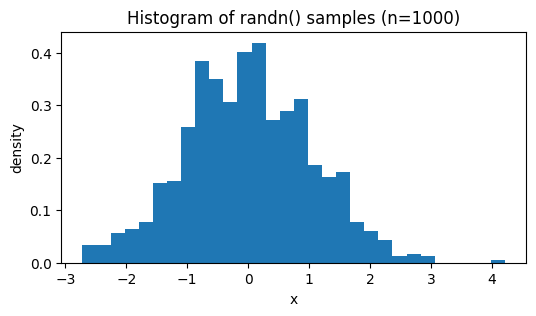

In [ ]:
#@title Fix the following function:
# This cell implements Gaussian sampling using the Box–Muller transform. [web:96]
# Run it to visually sanity-check that the histogram looks roughly normal. [web:164]

import random
import math
import matplotlib.pyplot as plt

# -------------------------
# Student task (fill blanks)
# -------------------------

### MODIFY THIS FUNCTION ONLY
def randn(mu=0.0, sigma=1.0):
    u1 = 1.0 - random.random()
    u2 = ...
    z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos( ... )
    return ... + sigma * ...
### MODIFY THIS FUNCTION ONLY


# -------------------------
# Quick test / visualization
# -------------------------
def test_randn(n=1000, bins=30, mu=0.0, sigma=1.0, seed=0):
    random.seed(seed)
    x = [randn(mu, sigma) for _ in range(n)]

    plt.figure(figsize=(6, 3))
    plt.hist(x, bins=bins, density=True)  # bins controls histogram resolution.
    plt.title(f"Histogram of randn() samples (n={n})")
    plt.xlabel("x")
    plt.ylabel("density")
    plt.show()

test_randn()


Answer.

### Q2. Sampling from a Uniform distribution

If your answer to the previous question is correct, you may have noticed that to generate random numbers from a normal distribution, we first need random numbers from a uniform distribution.



```
random.random()  
```



How do libraries generate samples from a uniform distribution, and are these functions truly random?

Answer.

###Q3. Exploring the source of $\sqrt{\Delta t}$

In the class we saw how to approximate integration of a Stochastic Differential Equation

$$d x_t = v(x_t, t) dt + 1 dW_t$$

would have the formula:

$$ x_{k+1} = x_k + v(x_t, t) \Delta t + 1 \sqrt{\Delta t} Z $$
Try to find the intuition behind the presence of $\sqrt{\Delta t}$ in that expression.


Answer.

###Q4. Understanding Euler–Maruyama and simulating SDEs

Look up the Euler–Maruyama integrator online and try to understand what problem it solves and how it approximates a stochastic differential equation (SDE).
Then read the code below and identify the role of the drift function v(x,t): what does it represent, and how does it influence the motion of the particles?
Finally, complete the missing parts of the implementation and use it to simulate a few examples—compare what happens with no noise versus with noise, and observe how the particle trajectories change.


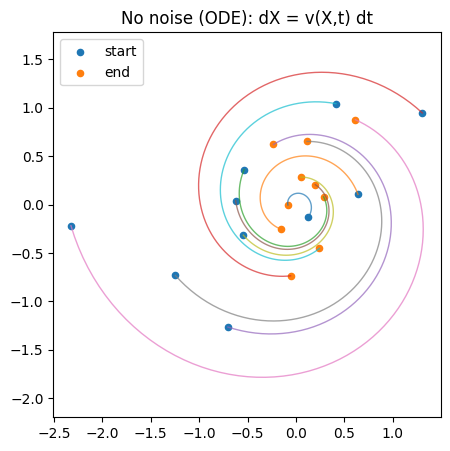

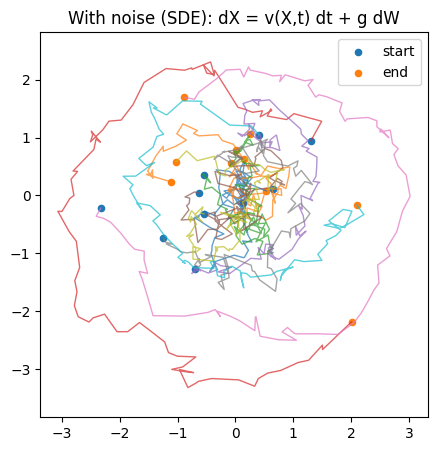

In [ ]:
#@title Euler–Maruyama integrator (2D particles)
# This cell contains:
# 1) An Euler–Maruyama SDE solver for 2D particles (students complete a few lines).
# 2) A plotting helper to visualize trajectories.
# 3) A small demo comparing "no noise" vs "with noise".

import numpy as np
import matplotlib.pyplot as plt


def euler_maruyama(
    x0,        # (N, 2) array of initial particle positions
    v,         # drift function: v(x, t) -> (N, 2)
    g,         # noise strength: g(x, t) -> scalar (for this lab)
    T=1.0,     # final time
    n_steps=200,
    noise=True,
    seed=0,
):
    """
    Simulate the 2D SDE (Itô form):
        dX_t = v(X_t, t) dt + g(X_t, t) dW_t

    Euler–Maruyama time-discretization:
        X_{k+1} = X_k + v(X_k, t_k) * dt + g(X_k, t_k) * dW_k
    where
        dW_k = sqrt(dt) * Z_k,   Z_k ~ N(0, I)

    If noise=False, we set dW_k = 0 and the update becomes a standard ODE Euler step.
    """
    rng = np.random.default_rng(seed)

    # Make sure x is a float array of shape (N, 2)
    x = np.array(x0, dtype=float)
    N = x.shape[0]

    # Time step size
    dt = T / n_steps

    # Store all particle positions over time:
    # traj[k] will be an (N, 2) array containing all particle positions at time step k
    traj = np.zeros((n_steps + 1, N, 2), dtype=float)
    traj[0] = x

    # Current time
    t = 0.0

    for k in range(n_steps):
        # Drift term (deterministic part)
        drift = v(x, t)  # shape (N, 2)

        # Brownian increment (random part)
        if noise:
            # Z ~ N(0, I) for each particle
            Z = rng.standard_normal(size=(N, 2))
            # dW = sqrt(dt) * Z  (this is the key Brownian scaling)
            dW = np.sqrt(dt) * Z
        else:
            # No noise => dW = 0
            dW = np.zeros((N, 2))

        # Noise scale (diffusion coefficient). In this lab, keep it simple: g returns a scalar.
        gg = g(x, t)

        # -----------------------
        # STUDENTS: MODIFY BELOW
        # -----------------------
        # Diffusion term (random update)
        diffusion = gg * dW

        # Full Euler–Maruyama update:
        # x_{k+1} = x_k + drift*dt + diffusion
        x = x + drift *dt + diffusion

        # Advance time
        t = t + dt

        # Save new positions
        traj[k + 1] = x
        # -----------------------
        # STUDENTS: MODIFY ABOVE
        # -----------------------

    # Return time grid + trajectories
    ts = np.linspace(0.0, T, n_steps + 1)
    return ts, traj


def plot_trajectories_2d(traj, title="", every=5, alpha=0.7):
    """
    Plot 2D particle trajectories.

    traj has shape (K, N, 2):
      K = number of stored time points
      N = number of particles
      2 = x/y coordinates
    """
    K, N, _ = traj.shape

    plt.figure(figsize=(5, 5))

    # Plot each particle path (thin line)
    for i in range(N):
        plt.plot(traj[::every, i, 0], traj[::every, i, 1], lw=1, alpha=alpha)

    # Mark the start and end points
    plt.scatter(traj[0, :, 0], traj[0, :, 1], s=20, label="start")
    plt.scatter(traj[-1, :, 0], traj[-1, :, 1], s=20, label="end")

    plt.axis("equal")
    plt.title(title)
    plt.legend()
    plt.show()


#@title Demo: particles with and without noise
# This demo defines a simple drift v that spirals toward the origin.
# Then it runs the simulation twice:
#  - noise=False: deterministic ODE
#  - noise=True: stochastic SDE

def v(x, t):
    """
    Drift: rotation + contraction.
    This makes trajectories spiral inward (without noise).
    """
    A = np.array([[0.0, -1.0],
                  [1.0,  0.0]])   # rotation matrix (90 degrees)
    return (x @ A.T) - 0.2 * x    # rotate then pull toward origin


def g(x, t):
    """
    Diffusion (noise strength).
    Returning a constant scalar means isotropic noise with fixed magnitude.
    Set this to 0.0 to recover the ODE.
    """
    return 0.6


# Initial particles: 10 points drawn from a standard normal in R^2
rng = np.random.default_rng(0)
x0 = rng.normal(size=(10, 2))

# Run without noise (ODE)
ts, traj_det = euler_maruyama(x0, v, g, T=4.0, n_steps=400, noise=False, seed=0)

# Run with noise (SDE)
ts, traj_sto = euler_maruyama(x0, v, g, T=4.0, n_steps=400, noise=True, seed=0)

# Plot both
plot_trajectories_2d(traj_det, title="No noise (ODE): dX = v(X,t) dt")
plot_trajectories_2d(traj_sto, title="With noise (SDE): dX = v(X,t) dt + g dW")


###Q5. Long-time behavior and the effect of noise

As the final time T → ∞, do the simulated particles converge to the origin (0,0) (e.g., in probability or in distribution)? How does changing the diffusion term g(x,t) (i.e., the noise strength/structure) affect whether the system converges, and if it does not converge to a point, what long-time behavior is observed (e.g., a stationary distribution around the origin)?


dt = 0.1237


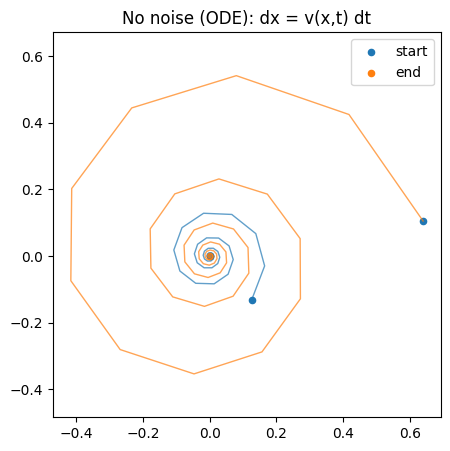

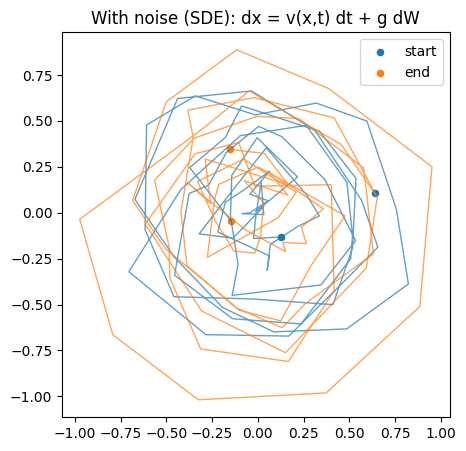


Q5. As T goes to infinity, do the particles converge to (0,0)?
    What happens if we change g (the noise scale)? Do we get convergence then?


In [ ]:
#@title Simulate ODE vs SDE in 2D { run: "auto" }
#@markdown Use the sliders to change the final time \(T\), the noise scale \(g\), and the number of steps.
#@markdown Euler–Maruyama uses \(\Delta W=\sqrt{\Delta t}\,Z\) with \(Z\sim\mathcal N(0,1)\). [web:1]

import numpy as np
import matplotlib.pyplot as plt

# --- Parameters (Colab Forms) ---
seed = 0  #@param {type:"integer"}
N = 2    #@param {type:"slider", min:2, max:500, step:1}
T = 49.5  #@param {type:"slider", min:0.5, max:100.0, step:0.5}
n_steps = 400  #@param {type:"slider", min:50, max:4000, step:50}
g_scale = 0.15  #@param {type:"slider", min:0.0, max:3.0, step:0.05}

# If you want to explore "convergence", it helps to keep dt = T/n_steps reasonable.
dt = T / n_steps
print(f"dt = {dt:.4f}")

# --- Initial points ---
rng = np.random.default_rng(seed)
x0 = rng.normal(size=(N, 2))

# --- Example drift: spiral into the origin ---
def v(x, t):
    A = np.array([[0.0, -1.0],
                  [1.0,  0.0]])      # rotation
    return (x @ A.T) - 0.2 * x       # contraction

# --- Noise strength (diffusion) ---
def g(x, t):
    return g_scale

# --- Run simulations ---
ts, traj_det = euler_maruyama(x0, v, g, T=T, n_steps=n_steps, noise=False, seed=seed)
ts, traj_sto = euler_maruyama(x0, v, g, T=T, n_steps=n_steps, noise=True,  seed=seed)

# --- Plot ---
plot_trajectories_2d(traj_det, title="No noise (ODE): dx = v(x,t) dt")
plot_trajectories_2d(traj_sto, title="With noise (SDE): dx = v(x,t) dt + g dW")


### Q5. Score Matching Basics

Open Song’s paper on score-based generative modeling:
https://arxiv.org/pdf/2011.13456

In Figure 2, it is mentioned that the score term $ \nabla \log p_t(x) $ (and related quantities like $ \nabla p_t(x) $, up to normalization) must be estimated.

Why do we need to estimate this quantity in score-based models, and how can it be estimated in practice?

Answer.